# Coastal Access & Amenities Analysis of Oʻahu, Hawaiʻi

##### A spatial analysis of shoreline public access points and amenities on the island of Oʻahu, using GIS and Python.

This project explores how accessible Oʻahu’s shoreline is and evaluates the availability of key public amenities, including:
- Restrooms
- Showers
- Picnic facilities
- Trash receptacles
- Drinking water
- Phones
- Lifeguards

Using a combination of GIS shapefiles, CSV amenity data, and Python-based analysis, this project provides insights into distribution of public shoreline access points, density of coastal amenities, spatial patterns of well-served vs under-served regions, and a fully interactive map of Oʻahu coastal access points.

## Part 1: Categorizing the data into regions

(North Shore, South Shore, Leeward Coast, Windward Coast)

In [3]:
import geopandas as gpd
import folium

# 1. Load the shoreline shapefile
shp_path = "Shoreline_Public_Access.shp"  # <-- update path if needed
gdf = gpd.read_file(shp_path)

# 2. Convert to WGS84 (lat/lon) just to be safe
gdf = gdf.to_crs(epsg=4326)

# 3. Add latitude & longitude columns from geometry
gdf["latitude"] = gdf.geometry.y
gdf["longitude"] = gdf.geometry.x


# 4. Region classification function
#    This guarantees EVERY point gets one of the 4 regions (no "Other").
def classify_region(lat, lon):
    # Windward Coast: east side, mid-to-northern latitudes
    if lon >= -157.90 and lat >= 21.35:
        return "Windward Coast"

    # Leeward Coast: far west side
    if lon <= -158.10:
        return "Leeward Coast"

    # South Shore: southern band of the island
    if lat <= 21.32:
        return "South Shore"

    # Everything else: northern arc = North Shore
    return "North Shore"


# 5. Apply the classification
gdf["region"] = gdf.apply(
    lambda row: classify_region(row["latitude"], row["longitude"]),
    axis=1
)

# --- MANUAL REGION OVERRIDES ---

south_shore_overrides = [
    "West Loch Shoreline Park",
    "Iriquois Point A",
    "Neil S Blaisdell Park",
    "Aiea Bay State Recreational Area",
    "Lagoon Drive",
    "Ke'ehi Lagoon Park"
]

windward_overrides = [
    "Bellows Field Beach Park",
    "Waimanalo Bay Beach Park",
    "Laumilo A",
    "Laumilo B",
    "Laumilo C",
    "Laumilo D",
    "Laumilo E",
    "Laumilo F",
    "Laumilo G",
    "Laumilo H",
    "Laumilo I",
    "Waimanalo Beach Park",
    "Kaiona Beach Park"
]

# Apply overrides
gdf.loc[gdf["name"].isin(south_shore_overrides), "region"] = "South Shore"
gdf.loc[gdf["name"].isin(windward_overrides), "region"] = "Windward Coast"

# (Optional) See how many points per region
print(gdf["region"].value_counts())


# 6. Build the folium map (NO gray points)
center_lat = gdf["latitude"].mean()
center_lon = gdf["longitude"].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=10)

region_colors = {
    "North Shore": "green",
    "Leeward Coast": "red",
    "South Shore": "purple",
    "Windward Coast": "blue"
}

for _, row in gdf.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=4,
        color=region_colors[row["region"]],
        fill=True,
        fill_opacity=0.9,
        popup=f"{row['name']}<br>Region: {row['region']}"
    ).add_to(m)

m


region
South Shore       74
Windward Coast    50
Leeward Coast     45
North Shore       40
Name: count, dtype: int64


## Part 2: Analysis

In [6]:
# Define amenity_cols
amenity_cols = [
    "restroom", "showers", "picnic_fac",
    "trash_rece", "water", "phone", "lifeguard"
]

In [8]:
def to_binary(series):
    return (
        series.astype(str)
              .str.strip()
              .str.upper()
              .map({
                  "YES": 1,
                  "NO": 0,
                  "UNKNOWN": 0,
                  "Y": 1, "N": 0,   # just in case
                  "1": 1, "0": 0    # also in case
              })
              .fillna(0)
              .astype(int)
    )

# Apply conversion
for col in amenity_cols:
    gdf[col] = to_binary(gdf[col])

gdf[amenity_cols].head()

,restroom,showers,picnic_fac,trash_rece,water,phone,lifeguard
0,1,1,1,1,1,0,0
1,1,1,1,1,1,0,0
2,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1


In [9]:
gdf["amenity_score"] = gdf[amenity_cols].sum(axis=1)
gdf[["amenity_score"] + amenity_cols].head()

,amenity_score,restroom,showers,picnic_fac,trash_rece,water,phone,lifeguard
0,5,1,1,1,1,1,0,0
1,5,1,1,1,1,1,0,0
2,7,1,1,1,1,1,1,1
3,7,1,1,1,1,1,1,1
4,7,1,1,1,1,1,1,1


In [10]:
print("Amenity Counts:\n")
for col in amenity_cols:
    print(f"{col}: {gdf[col].sum()}")

Amenity Counts:

restroom: 79
showers: 72
picnic_fac: 64
trash_rece: 132
water: 80
phone: 46
lifeguard: 29


In [11]:
gdf["amenity_score"].describe()

count    209.000000
mean       2.401914
std        2.583453
min        0.000000
25%        0.000000
50%        1.000000
75%        5.000000
max        7.000000
Name: amenity_score, dtype: float64

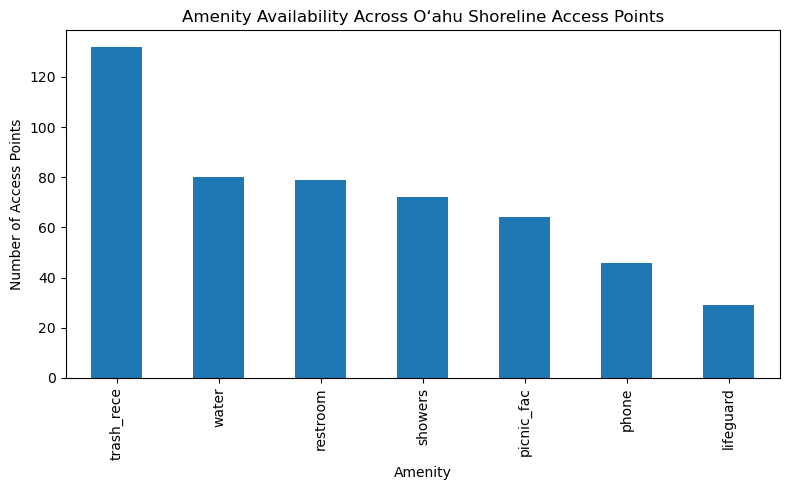

In [12]:
import matplotlib.pyplot as plt

amenity_counts = gdf[amenity_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(8,5))
amenity_counts.plot(kind="bar")
plt.title("Amenity Availability Across Oʻahu Shoreline Access Points")
plt.xlabel("Amenity")
plt.ylabel("Number of Access Points")
plt.tight_layout()
plt.show()

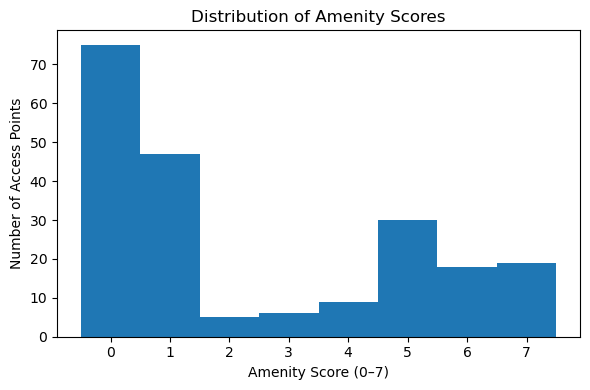

In [13]:
plt.figure(figsize=(6,4))
gdf["amenity_score"].plot(kind="hist", bins=range(0,9), align="left")
plt.title("Distribution of Amenity Scores")
plt.xlabel("Amenity Score (0–7)")
plt.ylabel("Number of Access Points")
plt.xticks(range(0,8))
plt.tight_layout()
plt.show()

In [14]:
region_means = gdf.groupby("region")[amenity_cols + ["amenity_score"]].mean()
region_means

,restroom,showers,picnic_fac,trash_rece,water,phone,lifeguard,amenity_score
region,,,,,,,,
Leeward Coast,0.577778,0.511111,0.355556,0.688889,0.555556,0.333333,0.133333,3.155556
North Shore,0.300000,0.300000,0.225000,0.800000,0.300000,0.125000,0.175000,2.225000
South Shore,0.351351,0.297297,0.337838,0.554054,0.364865,0.202703,0.121622,2.229730
Windward Coast,0.300000,0.300000,0.280000,0.560000,0.320000,0.220000,0.140000,2.120000
